# Using quantile regression for point / interval estimation

In [262]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor


## Build data

In [386]:
np.random.seed(32)
x = np.linspace(-10, 5, 1000)
y = x/2 + np.sin(x) + 0.4*np.random.randn(len(x))

# machine-learning like
X = x.reshape((len(x),1))


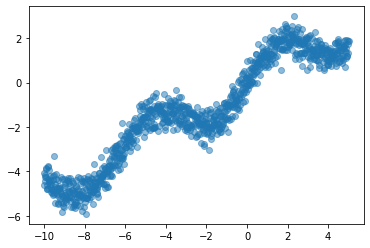

In [387]:
plt.scatter(x, y, alpha=0.5)
plt.show()

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Create quantile-wise models

In [389]:
dq = 0.05
quantiles = np.arange(dq, 1, dq).round(2)
quantiles

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [390]:
model_dict = {q: LGBMRegressor(objective='quantile', metric='quantile', 
                               alpha=q, random_state=int(10*q), reg_alpha=2, reg_lambda=2)
             for q in quantiles}

In [391]:
for q in quantiles:
    model_dict[q].fit(X_train, y_train)

In [392]:
X_test_ordered = np.sort(X_test, axis=0)

### Plot median and quantiles 10 and 90

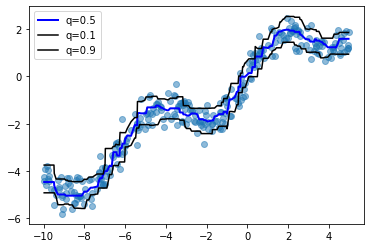

In [393]:
plt.scatter(X_test, y_test, alpha=0.5)
plt.plot(X_test_ordered, model_dict[0.5].predict(X_test_ordered), label='q=0.5', color='blue', lw=2)
plt.plot(X_test_ordered, model_dict[0.1].predict(X_test_ordered), label='q=0.1', color='black')
plt.plot(X_test_ordered, model_dict[0.90].predict(X_test_ordered), label='q=0.9', color='black')
plt.legend()
plt.show()

# Use quantiles to build means and standard deviations

Let $f_q: \mathcal X \to \mathcal Y$ be the quantile regression function for quantile $q$.


For any given $x$, what is the *mean* predicted value? 

For a random variable $Z$, letting $F(z) := \mathbb P(Z \leq z)$ be its CDF,

$$\begin{align*}
\mathbb E[Z] &= \int_{-\infty}^\infty z dF(z) = \int_0^1 F^{-1}(q) \; dq\\
             &= \int_0^1 g(q) \; dq
\end{align*}$$

where $g(q) \equiv F^{-1}(q)$ is the so-called *quantile function*.

This means we can calculate a mean by simply approximating the integral of the quantile function:

$$\mathbb E[Z] = \int_0^1 g(q) \; dq \approx \sum_{i=1}^N g(q_i) \Delta q$$

We have $g(q_i)$ - we can calculate it via the functions we just trained. It is the sum of predicted values times the difference in quantiles.

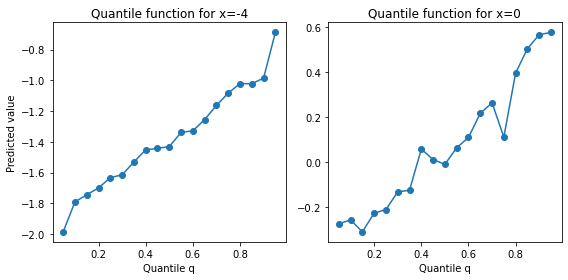

In [394]:
fig, ax =  plt.subplots(ncols=2, figsize=(8,4))
x = -4
y = [model_dict[q].predict(np.array([[x]]))[0] for q in quantiles]
ax[0].plot(quantiles, y, marker='o')
ax[0].set_xlabel("Quantile q")
ax[0].set_ylabel("Predicted value")
ax[0].set_title(f"Quantile function for {x=}")

x = 0
y = [model_dict[q].predict(np.array([[x]]))[0] for q in quantiles]
ax[1].plot(quantiles, y, marker='o')
ax[1].set_xlabel("Quantile q")
#ax[1].set_ylabel("Predicted value")
ax[1].set_title(f"Quantile function for {x=}")

plt.tight_layout()
plt.show()

OBS: this needs to be regularized so that quantiles are monotonic. We do this below:

In [395]:
def predict_mean(X, model_dict):
    quantiles = sorted(list(model_dict.keys()))
    dq = quantiles[1] - quantiles[0] 

    y = np.array([model_dict[q].predict(X) for q in quantiles])

    # regularize so that quantiles are monotonic
    y = np.array([np.maximum(el, np.pad(el, 1, mode='edge')[:-2]) for el in y.T]).T
    
    return np.sum(y, axis=0) * dq

In [396]:
y = predict_mean(X_test_ordered, model_dict)

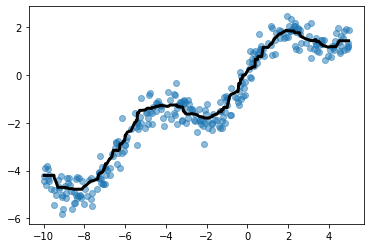

In [397]:
plt.plot(X_test_ordered, y, lw=3, color='black')
plt.scatter(X_test, y_test, alpha=0.5)
plt.show()

The same argument can be used to calculate a *standard deviation* for predictions:

$$\mathrm{Var}\, Z = \sqrt{\int_0^1 g^2(q) \; dq - \left(\int_0^1 g(q) \; dq \right)^2}$$

In [398]:
def predict_mean_and_std(X, model_dict):
    quantiles = sorted(list(model_dict.keys()))
    dq = quantiles[1] - quantiles[0]

    y = np.array([model_dict[q].predict(X) for q in quantiles])

    # regularize so that quantiles are monotonic
    y = np.array([np.maximum(el, np.pad(el, 1, mode='edge')[:-2]) for el in y.T]).T
    
    mean    = np.sum(y, axis=0) * dq
    squared = np.sum(y**2, axis=0) * dq

    return mean, np.sqrt(squared - mean**2)

In [399]:
y, sigma = predict_mean_and_std(X_test_ordered, model_dict)

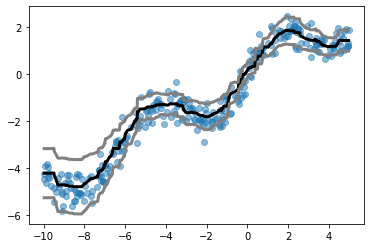

In [400]:
plt.plot(X_test_ordered, y, lw=3, color='black')
plt.plot(X_test_ordered, y+sigma, lw=3, color='grey')
plt.plot(X_test_ordered, y-sigma, lw=3, color='grey')

plt.scatter(X_test, y_test, alpha=0.5)
plt.show()

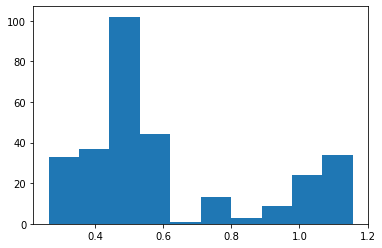

In [384]:
plt.hist(sigma)
plt.show()